# Instalar o tensorflow

In [1]:
!pip install tensorflow

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4848 sha256=1396d28338fff9769e98d0d55f05e17df7ce37a46d686c0109ffb872ee64e6f2
  Stored in directory: c:\users\joaop\appdata\local\pip\cache\wheels\b6\0d\90\0d1bbd99855f99cb2f6c2e5ff96f8023fad8ec367695f7d72d
Successfully built termcolor


In [207]:
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import scipy.io
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
import matplotlib.pyplot as plt
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_

In [185]:
BATCH_SIZE = 16

# 1. Recolher os dados

In [186]:
def get_data_from_mat(train_file,test_file):
    train_mat = scipy.io.loadmat(train_file) 
    test_mat = scipy.io.loadmat(test_file) 
    print(train_mat.keys())
    print(test_mat.keys())
    train_np = np.array(train_mat['train_data']).transpose(2,0,1)
    test_np = np.array(test_mat['test_data']).transpose(2,0,1)
    print('Train shape: ',train_np.shape)
    print('Test shape: ',test_np.shape)
    return  train_np, test_np


train_data, test_data = get_data_from_mat('train_data.mat','test_data.mat')

dict_keys(['__header__', '__version__', '__globals__', 'train_data'])
dict_keys(['__header__', '__version__', '__globals__', 'test_data'])
Train shape:  (112, 90, 90)
Test shape:  (28, 90, 90)


In [145]:
train_data[0].shape

(90, 90)

In [146]:
train_data[0]

array([[0.        , 0.        , 0.13152513, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.13152513, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.28060623],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.28060623, 0.        ,
        0.        ]])

# 2. Preparar os dados

## 2.1. Dataset de treino

In [187]:
#Tornar cada matriz num vetor de uma dimensão (passar de 90x90 para 8100) e armazenar todos os valores de cada matriz
#O dicionário utilizado armazena, todos os valores com indíce X, pertencentes às diferentes 112 matrizes, sendo esse índice
#a chave do dic.
#Por exemplo: dictAttributes[0] contém o primeiro elemento de cada vetor anteriormente criado
dictAttributes = dict()
for i in range(len(train_data)):# len(train_data) - 112
    flatten_data = train_data[i].flatten()
    for j in range(len(flatten_data)):
        dictAttributes.setdefault(j,list())
        dictAttributes[j].append(flatten_data[j])
len(dictAttributes)

8100

In [188]:
#Nesta fase criam-se colunas com todos os elementos que estão numa dada posição do vetor, a label da coluna é essa posição
scans_series = []
for k in dictAttributes.keys():
    scans_series.append(pd.Series(dictAttributes.get(k)))

In [189]:
train_data_series = pd.concat(scans_series,axis=1)
train_data_series

,0,1,2,3,4,5,6,7,8,9,...,8090,8091,8092,8093,8094,8095,8096,8097,8098,8099
0,0.0,0.0,0.131525,0.0,0.0,0.0,0.271538,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.585006,0.0,0.280606,0.0,0.0
1,0.0,0.0,0.117704,0.0,0.0,0.0,0.316890,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.599437,0.0,0.207478,0.0,0.0
2,0.0,0.0,0.155806,0.0,0.0,0.0,0.348072,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.630374,0.0,0.246472,0.0,0.0
3,0.0,0.0,0.145214,0.0,0.0,0.0,0.310270,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.562505,0.0,0.287888,0.0,0.0
4,0.0,0.0,0.161360,0.0,0.0,0.0,0.385560,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.564043,0.0,0.234284,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,0.0,0.0,0.215767,0.0,0.0,0.0,0.390332,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.011150,0.0,0.660292,0.0,0.302675,0.0,0.0
108,0.0,0.0,0.143005,0.0,0.0,0.0,0.306380,0.0,0.0,0.0,...,0.0,0.011171,0.0,0.019141,0.0,0.630415,0.0,0.204125,0.0,0.0
109,0.0,0.0,0.116085,0.0,0.0,0.0,0.290941,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.574355,0.0,0.246784,0.0,0.0
110,0.0,0.0,0.156654,0.0,0.0,0.0,0.357540,0.0,0.0,0.0,...,0.0,0.010225,0.0,0.000000,0.0,0.631057,0.0,0.216259,0.0,0.0


In [190]:
TRAIN_CSV_PATH = 'train.csv'

In [191]:
rest_train_df = pd.read_csv(TRAIN_CSV_PATH)
rest_train_df.head(10) #Tem 112 linhas

,id,age,sex,education
0,1,13,1,7
1,2,14,0,8
2,3,15,1,9
3,4,15,1,9
4,5,15,1,9
5,6,15,1,9
6,7,16,0,10
7,8,16,1,10
8,9,16,0,10
9,10,17,0,11


In [192]:
targets_train = rest_train_df['age']
targets_train

0      13
1      14
2      15
3      15
4      15
       ..
107    77
108    67
109    55
110    76
111    69
Name: age, Length: 112, dtype: int64

In [193]:
train_data_series = pd.concat([targets_train] + scans_series,axis=1).sample(frac=1.0, random_state=2022).reset_index(drop=True)
train_data_series

,age,0,1,2,3,4,5,6,7,8,...,8090,8091,8092,8093,8094,8095,8096,8097,8098,8099
0,53,0.0,0.0,0.173673,0.019753,0.0,0.0,0.399909,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.615459,0.0,0.113210,0.0,0.0
1,40,0.0,0.0,0.122071,0.000000,0.0,0.0,0.295469,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.596293,0.0,0.256004,0.0,0.0
2,69,0.0,0.0,0.330159,0.000000,0.0,0.0,0.389147,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.676865,0.0,0.197393,0.0,0.0
3,24,0.0,0.0,0.144803,0.000000,0.0,0.0,0.352847,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.653635,0.0,0.227650,0.0,0.0
4,55,0.0,0.0,0.116085,0.000000,0.0,0.0,0.290941,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.574355,0.0,0.246784,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,63,0.0,0.0,0.153905,0.000000,0.0,0.0,0.272740,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.577098,0.0,0.194381,0.0,0.0
108,61,0.0,0.0,0.178360,0.000000,0.0,0.0,0.306510,0.0,0.0,...,0.0,0.011916,0.0,0.0,0.0,0.723154,0.0,0.200323,0.0,0.0
109,22,0.0,0.0,0.134661,0.000000,0.0,0.0,0.361852,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.532999,0.0,0.238360,0.0,0.0
110,27,0.0,0.0,0.116392,0.000000,0.0,0.0,0.303962,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.570106,0.0,0.231983,0.0,0.0


In [194]:
train_df_all = pd.DataFrame(train_data_series)
train_df_all

,age,0,1,2,3,4,5,6,7,8,...,8090,8091,8092,8093,8094,8095,8096,8097,8098,8099
0,53,0.0,0.0,0.173673,0.019753,0.0,0.0,0.399909,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.615459,0.0,0.113210,0.0,0.0
1,40,0.0,0.0,0.122071,0.000000,0.0,0.0,0.295469,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.596293,0.0,0.256004,0.0,0.0
2,69,0.0,0.0,0.330159,0.000000,0.0,0.0,0.389147,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.676865,0.0,0.197393,0.0,0.0
3,24,0.0,0.0,0.144803,0.000000,0.0,0.0,0.352847,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.653635,0.0,0.227650,0.0,0.0
4,55,0.0,0.0,0.116085,0.000000,0.0,0.0,0.290941,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.574355,0.0,0.246784,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,63,0.0,0.0,0.153905,0.000000,0.0,0.0,0.272740,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.577098,0.0,0.194381,0.0,0.0
108,61,0.0,0.0,0.178360,0.000000,0.0,0.0,0.306510,0.0,0.0,...,0.0,0.011916,0.0,0.0,0.0,0.723154,0.0,0.200323,0.0,0.0
109,22,0.0,0.0,0.134661,0.000000,0.0,0.0,0.361852,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.532999,0.0,0.238360,0.0,0.0
110,27,0.0,0.0,0.116392,0.000000,0.0,0.0,0.303962,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.570106,0.0,0.231983,0.0,0.0


## 2.2. Dataset de validação

In [195]:
train_df, val_df = train_test_split(train_df_all, train_size = 0.7, shuffle=True, random_state=2022)
print('Quantidade de casos para treino: ', len(train_df))
print('Quantidade de casos para validação: ', len(val_df))

Quantidade de casos para treino:  78
Quantidade de casos para validação:  34


In [199]:
class MyDataset(Dataset):
    def __init__(self,train_df,validation_df):
        self.x_train = train_df.values[:,1:]
        self.y_train = train_df.values[:,0]
        self.x_val = validation_df.values[:,1:]
        self.y_val = validation_df.values[:,0]
        
        self.x_train = self.x_train.astype('float32')
        self.x_val = self.x_val.astype('float32')
        self.y_train = LabelEncoder().fit_transform(self.y_train)
        self.y_val = LabelEncoder().fit_transform(self.y_val)
        self.y_train = self.y_train.astype('long')
        self.y_val = self.y_val.astype('long')
        
    def __len_train__(self):
        return len(self.x_train)
    
    def __len_test__(self):
        return len(self.x_val)
    
    def __getitem_train__(self, idx):
        return [self.x_train[idx], self.y_train[idx]]
    
    def __getitem_test__(self, idx):
        return [self.x_val[idx], self.y_val[idx]]
    
    def get_splits_flat(self):
        x_train = torch.from_numpy(np.array(self.x_train))
        y_train = torch.from_numpy(np.array(self.y_train))
        x_val = torch.from_numpy(np.array(self.x_val))
        y_val = torch.from_numpy(np.array(self.y_val))
        train = torch.utils.data.TensorDataset(x_train,y_train)
        val = torch.utils.data.TensorDataset(x_val,y_val)
        return train, val

In [200]:
def prepare_data_flat(df_train, df_validation):
    dataset = MyDataset(df_train, df_validation)
    train, validation = dataset.get_splits_flat()
    
    train_dl = DataLoader(train, batch_size = BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(validation, batch_size = BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size = len(train), shuffle=False)
    val_dl_all = DataLoader(validation, batch_size = len(validation), shuffle=False)
    return train_dl, val_dl, train_dl_all, val_dl_all

train_dl, val_dl, train_dl_all, val_dl_all = prepare_data_flat(train_df, val_df)

# 3. Visualizar os dados

In [201]:
from IPython.display import display

def visualize_data(df):
    display(df)
    
def visualize_dataset(train_dl, test_dl):
    print(f"Quantidade de casos de Treino:{len(train_dl.dataset)}")
    print(f"Quantidade de casos de Teste:{len(test_dl.dataset)}")
    x, y = next(iter(train_dl))
    print(f"Shape tensor batch casos treino, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(test_dl))
    print(f"Shape tensor batch casos test, input: {x.shape}, output: {y.shape}")
    print(y)
    
visualize_data(train_df)
visualize_dataset(train_dl, val_dl)

,age,0,1,2,3,4,5,6,7,8,...,8090,8091,8092,8093,8094,8095,8096,8097,8098,8099
32,15,0.0,0.0,0.161360,0.000000,0.0,0.0,0.385560,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.564043,0.0,0.234284,0.0,0.0
71,62,0.0,0.0,0.190789,0.000000,0.0,0.0,0.372164,0.0,0.0,...,0.0,0.010886,0.0,0.000000,0.0,0.647107,0.0,0.205002,0.0,0.0
60,24,0.0,0.0,0.121891,0.000000,0.0,0.0,0.355104,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.636254,0.0,0.211628,0.0,0.0
1,40,0.0,0.0,0.122071,0.000000,0.0,0.0,0.295469,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.596293,0.0,0.256004,0.0,0.0
25,74,0.0,0.0,0.183769,0.017489,0.0,0.0,0.311366,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.599740,0.0,0.256305,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,15,0.0,0.0,0.155806,0.000000,0.0,0.0,0.348072,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.630374,0.0,0.246472,0.0,0.0
55,55,0.0,0.0,0.169237,0.010969,0.0,0.0,0.364563,0.0,0.0,...,0.0,0.000000,0.0,0.010407,0.0,0.634621,0.0,0.311531,0.0,0.0
49,33,0.0,0.0,0.129690,0.000000,0.0,0.0,0.298151,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.644189,0.0,0.268719,0.0,0.0
45,17,0.0,0.0,0.126655,0.000000,0.0,0.0,0.325666,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.595414,0.0,0.227950,0.0,0.0


Quantidade de casos de Treino:78
Quantidade de casos de Teste:34
Shape tensor batch casos treino, input: torch.Size([16, 8100]), output: torch.Size([16])
Shape tensor batch casos test, input: torch.Size([16, 8100]), output: torch.Size([16])
tensor([ 7, 21, 15, 13, 14,  5,  3, 19, 15, 13,  0,  1, 17,  1, 16,  6],
       dtype=torch.int32)


torch.Size([16, 8100])
torch.Size([16, 1, 90, 90])


C:\Users\joaop\AppData\Local\Temp\ipykernel_16444\2654971636.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


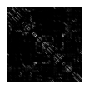

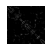

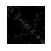

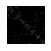

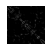

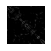

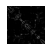

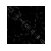

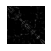

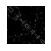

In [202]:
def visualize_scans_flat(dl):
    i, (inputs, targets) = next(enumerate(dl))
    print(inputs.shape)
    inputs = inputs.reshape(len(inputs), 1, 90, 90)
    print(inputs.shape)
    plt.figure(figsize=(8,8))
    for i in range(10):
        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.grid(b=None)
        plt.imshow(inputs[i][0], cmap='gray')
        plt.show()
    
visualize_scans_flat(train_dl)

# 4. Definir o modelo

In [175]:
!pip install torchinfo

In [215]:
device = torch.device("cpu")

from torchinfo import summary

class MLP(Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        self.hidden1 = Linear(n_inputs, 256)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        self.hidden2 = Linear(256, 128)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        self.hidden4 = Linear(128, 48)
        xavier_uniform_(self.hidden4.weight)
        self.act4 = Softmax(dim=1)
        
    def forward(self, X):
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.hidden2(X)
        X = self.act2(X)
        X = self.hidden4(X)
        X = self.act4(X)
        return X
    
model = MLP(8100)
print(summary(model, input_size=(BATCH_SIZE, 8100), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      --                        --
├─Linear: 1-1                            [16, 256]                 2,073,856
├─ReLU: 1-2                              [16, 256]                 --
├─Linear: 1-3                            [16, 128]                 32,896
├─ReLU: 1-4                              [16, 128]                 --
├─Linear: 1-5                            [16, 48]                  6,192
├─Softmax: 1-6                           [16, 48]                  --
Total params: 2,112,944
Trainable params: 2,112,944
Non-trainable params: 0
Total mult-adds (M): 33.81
Input size (MB): 0.52
Forward/backward pass size (MB): 0.06
Params size (MB): 8.45
Estimated Total Size (MB): 9.03


MLP(
  (hidden1): Linear(in_features=8100, out_features=256, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=256, out_features=128, bias=True)
  (act2): ReLU()
  (hidden4): Linear(in_features=128, out_features=48, bias=True)
  (act4): Softmax(dim=1)
)

# 5. Treinar o modelo

In [180]:
!pip install livelossplot

In [216]:
from livelossplot import PlotLosses
EPOCHS = 150
LEARNING_RATE = 0.01

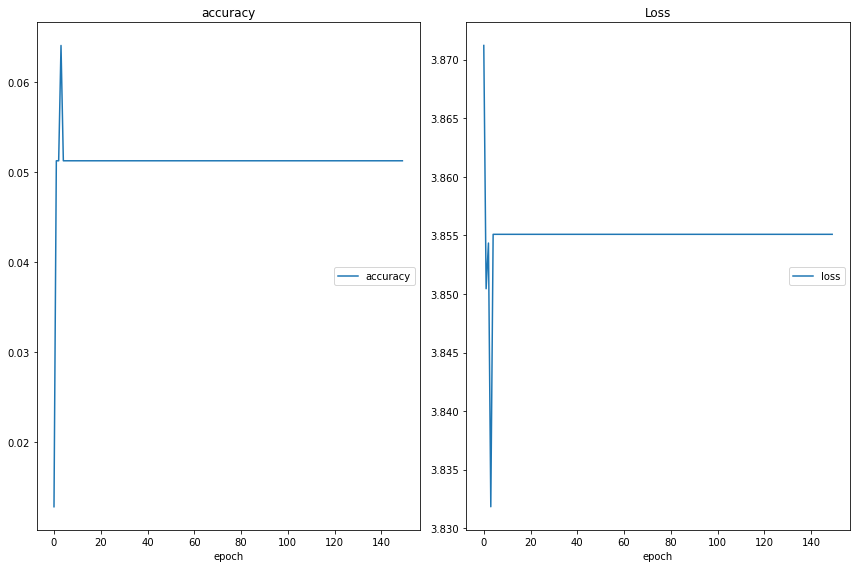

accuracy
	accuracy         	 (min:    0.013, max:    0.064, cur:    0.051)
Loss
	loss             	 (min:    3.832, max:    3.871, cur:    3.855)


In [217]:
def train_model(train_dl, model):
    liveloss = PlotLosses()
    criterion = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    for epoch in range(EPOCHS):
        logs = {}
        epoch_loss  = 0 
        epoch_acc  = 0 
        for i, (inputs, labels) in enumerate(train_dl):
            #print(inputs)
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.long()
            print(labels)
            loss = criterion(outputs, labels)
            acc = accuracy_score(labels.numpy(), np.argmax(outputs.detach().numpy(), axis=1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
        print(f'Epoch {epoch:03}: | Loss: {epoch_loss/len(train_dl):.5f} | Acc: {epoch_acc/len(train_dl):.3f}')      
        logs['loss'] = epoch_loss
        logs['accuracy'] = epoch_acc/len(train_dl)
        liveloss.update(logs)
        liveloss.send()

train_model(train_dl_all, model)

# 6. Avaliar o modelo

real:[22] previsão:[22]
real:[9] previsão:[22]
real:[17] previsão:[22]
real:[1] previsão:[22]
real:[12] previsão:[22]
real:[3] previsão:[22]
real:[15] previsão:[22]
real:[17] previsão:[22]
real:[7] previsão:[22]
real:[16] previsão:[22]
real:[1] previsão:[22]
real:[13] previsão:[22]
real:[19] previsão:[22]
real:[13] previsão:[22]
real:[15] previsão:[22]
real:[0] previsão:[22]
real:[20] previsão:[22]
real:[8] previsão:[22]
real:[18] previsão:[22]
real:[18] previsão:[22]
real:[2] previsão:[22]
real:[14] previsão:[22]
real:[10] previsão:[22]
real:[21] previsão:[22]
real:[16] previsão:[22]
real:[13] previsão:[22]
real:[19] previsão:[22]
real:[0] previsão:[22]
real:[21] previsão:[22]
real:[1] previsão:[22]
real:[6] previsão:[22]
real:[4] previsão:[22]
real:[11] previsão:[22]
real:[5] previsão:[22]
Accuracy: 0.029

acertou:1 falhou:33
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        

C:\Users\joaop\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\joaop\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\joaop\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C

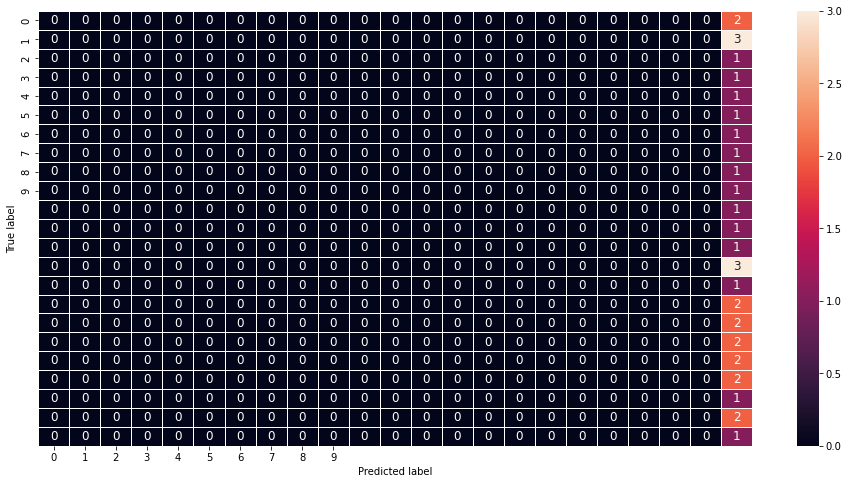

In [211]:
def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    for i, (inputs, labels) in enumerate(test_dl):
        yprev = model(inputs)
        yprev = yprev.detach().numpy()
        actual = labels.numpy()
        yprev = np.argmax(yprev, axis=1)
        actual = actual.reshape((len(actual), 1))
        yprev = yprev.reshape((len(yprev), 1))
        predictions.append(yprev)
        actual_values.append(actual)
    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return actual_values, predictions

def display_confusion_matrix(cm,list_classes):
    plt.figure(figsize = (16,8))
    sns.heatmap(cm,annot=True,xticklabels=list_classes,yticklabels=list_classes, annot_kws={"size": 12}, fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
actual_values, predictions = evaluate_model(val_dl, model)

acertou=0
falhou = 0
for r,p in zip(actual_values, predictions):
    print(f'real:{r} previsão:{p}')
    if r==p: acertou+=1  
    else: falhou+=1

acc = accuracy_score(actual_values, predictions)
print(f'Accuracy: {acc:0.3f}\n')
print(f'acertou:{acertou} falhou:{falhou}')

print(classification_report(actual_values, predictions))
cr = classification_report(actual_values, predictions, output_dict=True)
list_classes=list(cr.keys())[0:10]
cm = confusion_matrix(actual_values, predictions)

print (cm)
display_confusion_matrix(cm,list_classes)